In [5]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from statsmodels.tsa.arima.model import ARIMA
from nbeats_pytorch.model import NBeatsNet

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns



In [6]:
TIME_STEP = 5 # 定义步长 K
INPUT_DIM = 4
output_dim = 4
batch_size = 10  # 每轮训练模型时，样本的数量
epochs = 50  # 训练60轮次
hidden_size = 64
layer_num = 4
patience = 10
chunksize = 10000

reader = pd.read_csv(
    "/data/hmn_data/alibaba_cluster_data/MSRTQps_sort.csv", chunksize=chunksize)

In [7]:
tmp_df=pd.DataFrame()

for index, chunk in enumerate(reader):
    tmp_df = pd.concat([tmp_df, chunk])

In [8]:
# 获取所有唯一的id值
unique_ids = tmp_df['msinstanceid'].unique()


In [17]:
# 从唯一的id值中随机选择三个，不放回
train_ids = np.random.choice(unique_ids, 3, replace=False)
# 从唯一的id值中随机选择两个，不放回
val_ids = np.random.choice(unique_ids, 2, replace=False)
# 从唯一的id值中随机选择一个，不放回
test_ids = np.random.choice(unique_ids, 1, replace=False)

In [18]:
def load_df(df, selected_ids):
    # 提取包含所选id的所有行
    selected_rows = []
    for selected_id in selected_ids:
        # 或者使用 df.loc[df['msinstanceid'] == selected_id]
        rows = df.query('msinstanceid == @selected_id')
        selected_rows.append(rows)

    # 将提取的行组合成一个新的DataFrame
    selected_rows_df = pd.concat(selected_rows)
    return selected_rows_df


In [19]:
train_df = load_df(tmp_df, train_ids)
val_df = load_df(tmp_df, val_ids)
test_df = load_df(tmp_df, test_ids)

In [12]:
test_df

,Unnamed: 0,msinstanceid,timestamp,HTTP_MCR,HTTP_RT
14015040,19376,dc435513bccd62c194de30bb87f7d0bf80a8140c74be2d...,0,0.888889,0.888889
14015041,64171,dc435513bccd62c194de30bb87f7d0bf80a8140c74be2d...,120000,0.900000,0.900000
14015042,86555,dc435513bccd62c194de30bb87f7d0bf80a8140c74be2d...,180000,1.181818,1.181818
14015043,153810,dc435513bccd62c194de30bb87f7d0bf80a8140c74be2d...,360000,0.800000,0.800000
14015044,198645,dc435513bccd62c194de30bb87f7d0bf80a8140c74be2d...,480000,0.333333,0.333333
...,...,...,...,...,...
14015544,16134433,dc435513bccd62c194de30bb87f7d0bf80a8140c74be2d...,42960000,1.333333,1.333333
14015545,16156718,dc435513bccd62c194de30bb87f7d0bf80a8140c74be2d...,43020000,0.625000,0.625000
14015546,16178894,dc435513bccd62c194de30bb87f7d0bf80a8140c74be2d...,43080000,0.666667,0.666667
14015547,16201164,dc435513bccd62c194de30bb87f7d0bf80a8140c74be2d...,43140000,1.111111,1.111111


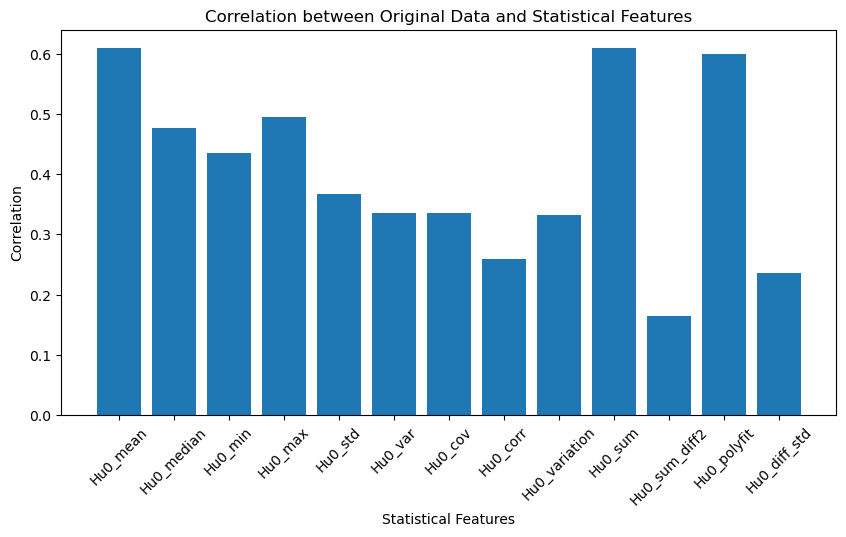

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设您的时间序列数据存储在一个名为data的列表中
data = test_df["HTTP_RT"]  # 请用您的实际数据替换
window_size = TIME_STEP

# 将数据转换为Pandas DataFrame
data_series = pd.Series(data)
df = pd.DataFrame({'Hu_0': data_series})
# 使用rolling滚动窗口，窗口大小为7
roll_data = df['Hu_0'].rolling(window=window_size)
df["Hu0_mean"] = roll_data.mean()
df["Hu0_median"] = roll_data.median()
df["Hu0_min"] = roll_data.min()
df["Hu0_max"] = roll_data.max()
df["Hu0_std"] = roll_data.std()
df["Hu0_var"] = roll_data.var()
df["Hu0_cov"] = df['Hu_0'].rolling(window=window_size).cov(df['Hu_0'])
df["Hu0_corr"] = df['Hu_0'].rolling(window=window_size).corr(df['Hu_0'])
df["Hu0_variation"] = df["Hu0_std"] / df["Hu0_mean"]
df["Hu0_sum"] = roll_data.sum()
df["Hu0_sum_diff2"] = df["Hu0_sum"].shift(1) - df["Hu0_sum"].shift(2)

# 计算线性拟合斜率
x = range(window_size)


def z(y): return np.polyfit(x, y, 1)[0] if len(y.dropna()) == window_size else np.nan


df["Hu0_polyfit"] = roll_data.apply(z)

# 计算一阶差分的均方差
roll_data_diff = df['Hu_0'].diff(1).rolling(window=window_size)
df["Hu0_diff_std"] = roll_data_diff.std()

# 删除有NaN值的行
df = df.dropna()

# 计算原始数据与新特征之间的相关性
correlations = df.corr().iloc[0, 1:].to_dict()

# 使用matplotlib绘制相关性图像
plt.figure(figsize=(10, 5))
plt.bar(correlations.keys(), correlations.values())
plt.xticks(rotation=45)
plt.xlabel("Statistical Features")
plt.ylabel("Correlation")
plt.title("Correlation between Original Data and Statistical Features")
plt.show()


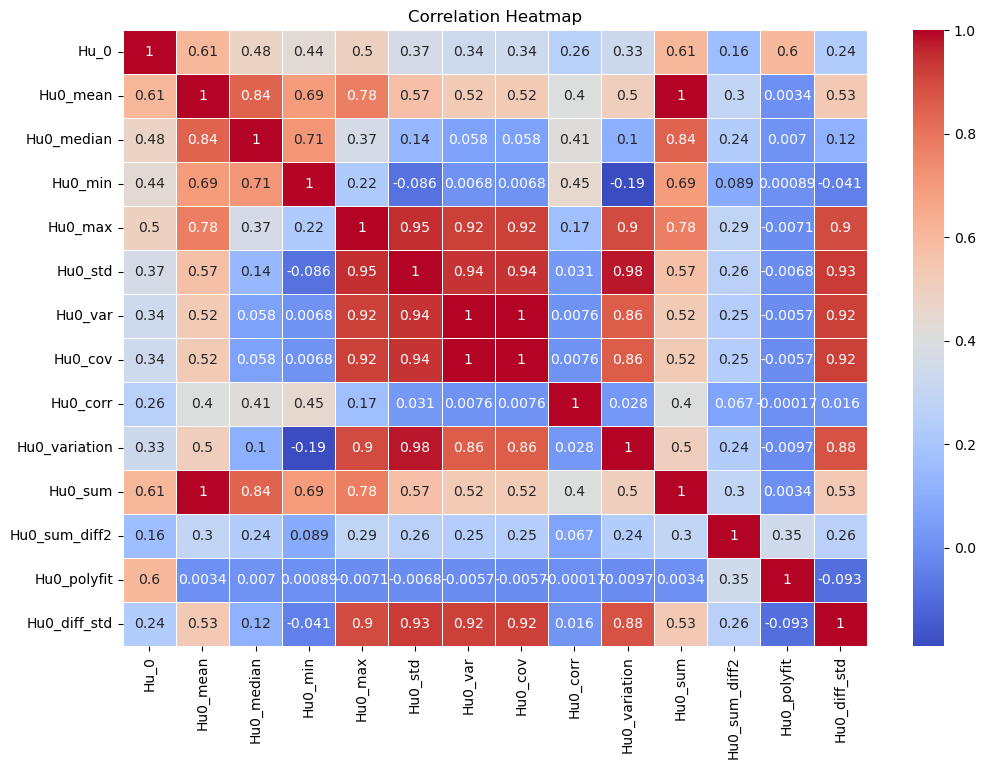

In [21]:
import seaborn as sns

# 计算相关性矩阵
corr_matrix = df.corr()

# 绘制热力图
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

In [22]:
import pywt

# 小波滤噪
def wavelet_denoising(data):
    # 小波函数取db8
    db4 = pywt.Wavelet('db8')

    # 分解
    coeffs = pywt.wavedec(data, db4)
    # 高频系数置零
    coeffs[len(coeffs) - 1] *= 0
    coeffs[len(coeffs) - 2] *= 0
    # 重构
    meta = pywt.waverec(coeffs, db4)
    meta = meta[:len(data)]
    return meta

In [23]:
df

,Hu_0,Hu0_mean,Hu0_median,Hu0_min,Hu0_max,Hu0_std,Hu0_var,Hu0_cov,Hu0_corr,Hu0_variation,Hu0_sum,Hu0_sum_diff2,Hu0_polyfit,Hu0_diff_std
7373490,1.160000,1.233935,1.243730,1.160000,1.274322,0.043633,0.001904,0.001904,1.0,0.035361,6.169673,-0.044185,-0.015775,0.055612
7373491,1.285828,1.240266,1.243730,1.160000,1.285828,0.049240,0.002425,0.002425,1.0,0.039701,6.201331,-0.121324,0.000675,0.086905
7373492,1.220553,1.235631,1.237450,1.160000,1.285828,0.049919,0.002492,0.002492,1.0,0.040399,6.178154,0.031658,-0.002229,0.092810
7373493,1.307263,1.249593,1.274322,1.160000,1.307263,0.059415,0.003530,0.003530,1.0,0.047547,6.247966,-0.023177,0.012643,0.101324
7373494,1.312401,1.257209,1.285828,1.160000,1.312401,0.065505,0.004291,0.004291,1.0,0.052104,6.286045,0.069812,0.032624,0.100521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7374200,1.219589,2.054603,2.209321,1.219589,2.478838,0.486395,0.236580,0.236580,1.0,0.236734,10.273015,1.399220,-0.176192,0.860240
7374201,1.075517,1.827842,2.103968,1.075517,2.478838,0.637160,0.405973,0.405973,1.0,0.348586,9.139211,0.109708,-0.325594,0.615903
7374202,1.067398,1.589062,1.219589,1.067398,2.478838,0.657496,0.432301,0.432301,1.0,0.413763,7.945310,-1.133805,-0.347646,0.609658
7374203,1.144239,1.397116,1.144239,1.067398,2.478838,0.607809,0.369431,0.369431,1.0,0.435045,6.985581,-1.193900,-0.282139,0.626248


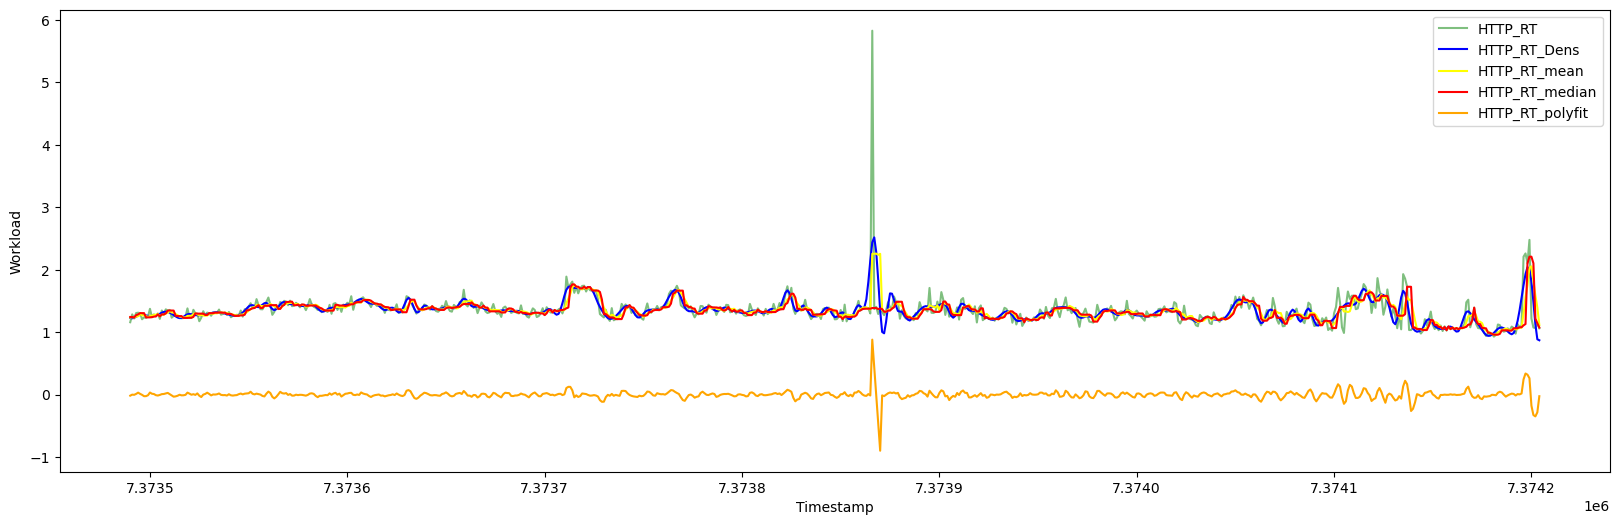

In [25]:


df["HTTP_RT_Dens"] = wavelet_denoising(df["Hu_0"])

plt.figure(figsize=(20, 6))
plt.plot(df["Hu_0"], label="HTTP_RT", color='green', alpha=0.5)
plt.plot(df["HTTP_RT_Dens"], label="HTTP_RT_Dens", color='blue')
plt.plot(df["Hu0_mean"], label="HTTP_RT_mean", color='yellow')
plt.plot(df["Hu0_median"], label="HTTP_RT_median", color='red')
plt.plot(df["Hu0_polyfit"], label="HTTP_RT_polyfit", color='orange')

plt.xlabel("Timestamp")
plt.ylabel("Workload")
plt.legend()
plt.show()
